In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np



In [3]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [4]:
from torchvision import datasets

In [5]:
# transforms, convert to greyscale, convert to tensor, normalize and move to cuda
trainTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

validTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

In [6]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=trainTransforms)

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=validTransforms)

In [7]:
trainDataset

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )

In [8]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 8
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True)   

In [9]:
print(trainLoader.dataset, testLoader.dataset)

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           ) Dataset ImageFolder
    Number of datapoints: 1500
    Root location: val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )


In [10]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        
        # define the decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2,padding=1),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [11]:
from torchsummary import summary
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(1, 3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
├─S

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
├─S

In [12]:
# Training batch
def trainBatch(input, model, criterion, optimiser):
    model.train()
    optimiser.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimiser.step()
    return loss

In [13]:
# validation batch
@torch.no_grad()
def validBatch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [14]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Train model over increasing epochs
numEpochs = 2
# Free the memory
import gc

# report
from torch_snippets import Report
log = Report(numEpochs)

for epoch in range(numEpochs):
    N = len(trainLoader)
    
    for index,(image,label) in enumerate(trainLoader):
        loss = trainBatch(image, model, criterion, optimiser)
        log.record(pos=(epoch + (index+1)/N), trn_loss=loss,end = '\r')
    
    N = len(testLoader)
    for index,(image,label) in enumerate(testLoader):
        loss = validBatch(image, model, criterion)
        log.record(pos=(epoch + (index+1)/N), val_loss=loss,end = '\r')
        
    
    log.report_avgs(epoch+1)
log.plot_epochs(log=True)

EPOCH: 0.244  trn_loss: 0.167  (31.29s - 225.38s remaining)

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


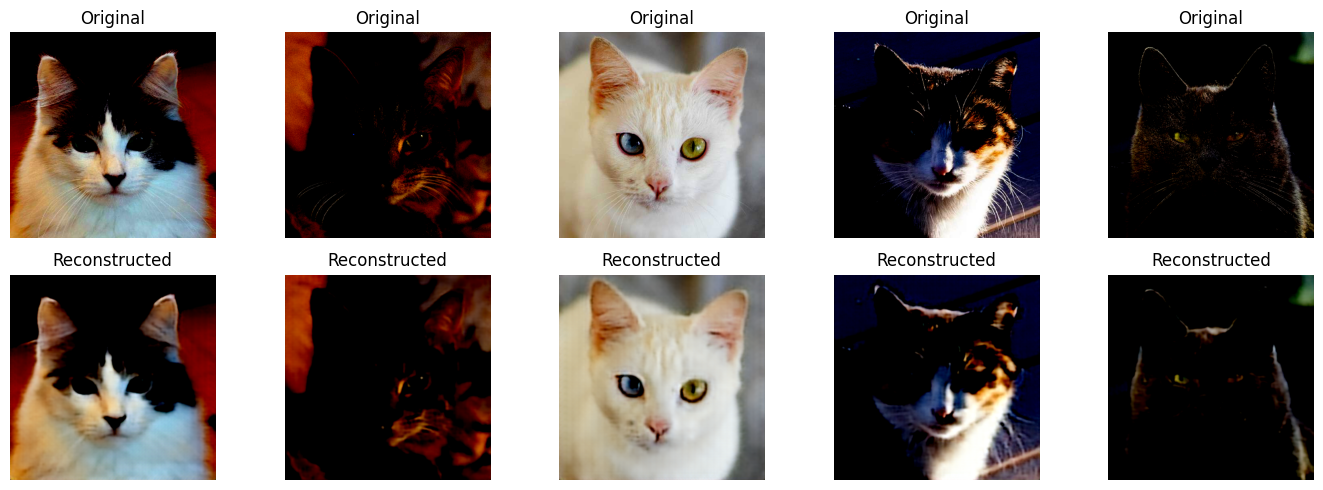

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 5 columns, transposed
fig, axs = plt.subplots(2, 5, figsize=(14, 5))

# Iterate over 5 images in the validation set
for i in range(5):
    # Get the i-th image, transform, and send to device
    image = validDataset[i][0].unsqueeze(0)
    
    # Get the reconstructed image
    with torch.no_grad():
        reconstructed = model(image)
        
    # Plot the original image
    axs[0, i].imshow(image[0].cpu().numpy().transpose(1, 2, 0))
    axs[0, i].set_title('Original')
    
    # Plot the reconstructed image
    axs[1, i].imshow(reconstructed[0].cpu().numpy().transpose(1, 2, 0))
    axs[1, i].set_title('Reconstructed')
    
    # Remove axes
    axs[0, i].axis('off')
    axs[1, i].axis('off')

# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
latent_vectors = []
classes = []
for im,clss in testLoader:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
    break
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(8, -1)

NameError: name 'testLoader' is not defined

In [ ]:
print(len(latent_vectors), len(latent_vectors[0]))

32 32768


In [ ]:
random_vectors = []
for columns in latent_vectors.transpose(1,0):
    mu, sigma = columns.mean(), columns.std()
    random_vectors.append(sigma*torch.randn(1,25) + mu)

In [ ]:
print(len(random_vectors), len(random_vectors[0]))

32768 1


In [ ]:
random_vectors[0].shape

torch.Size([1, 25])

In [ ]:
random_vectors = torch.cat(random_vectors).transpose(1,0).to(device)

In [ ]:
print(random_vectors.shape)

torch.Size([25, 32768])


In [ ]:
import matplotlib.pyplot as plt

# Assuming model and random_vectors are defined elsewhere

# Assuming model.decoder expects input shape (batch_size, channels, height, width)
image = model.decoder(random_vectors[0].view(1, 128, 32, 32)).view(512, 512, 3)

# Plot the image
plt.imshow(image.cpu().detach().numpy())
plt.show()


RuntimeError: shape '[1, 128, 32, 32]' is invalid for input of size 32768

RuntimeError: shape '[1, 128, 32, 32]' is invalid for input of size 32768

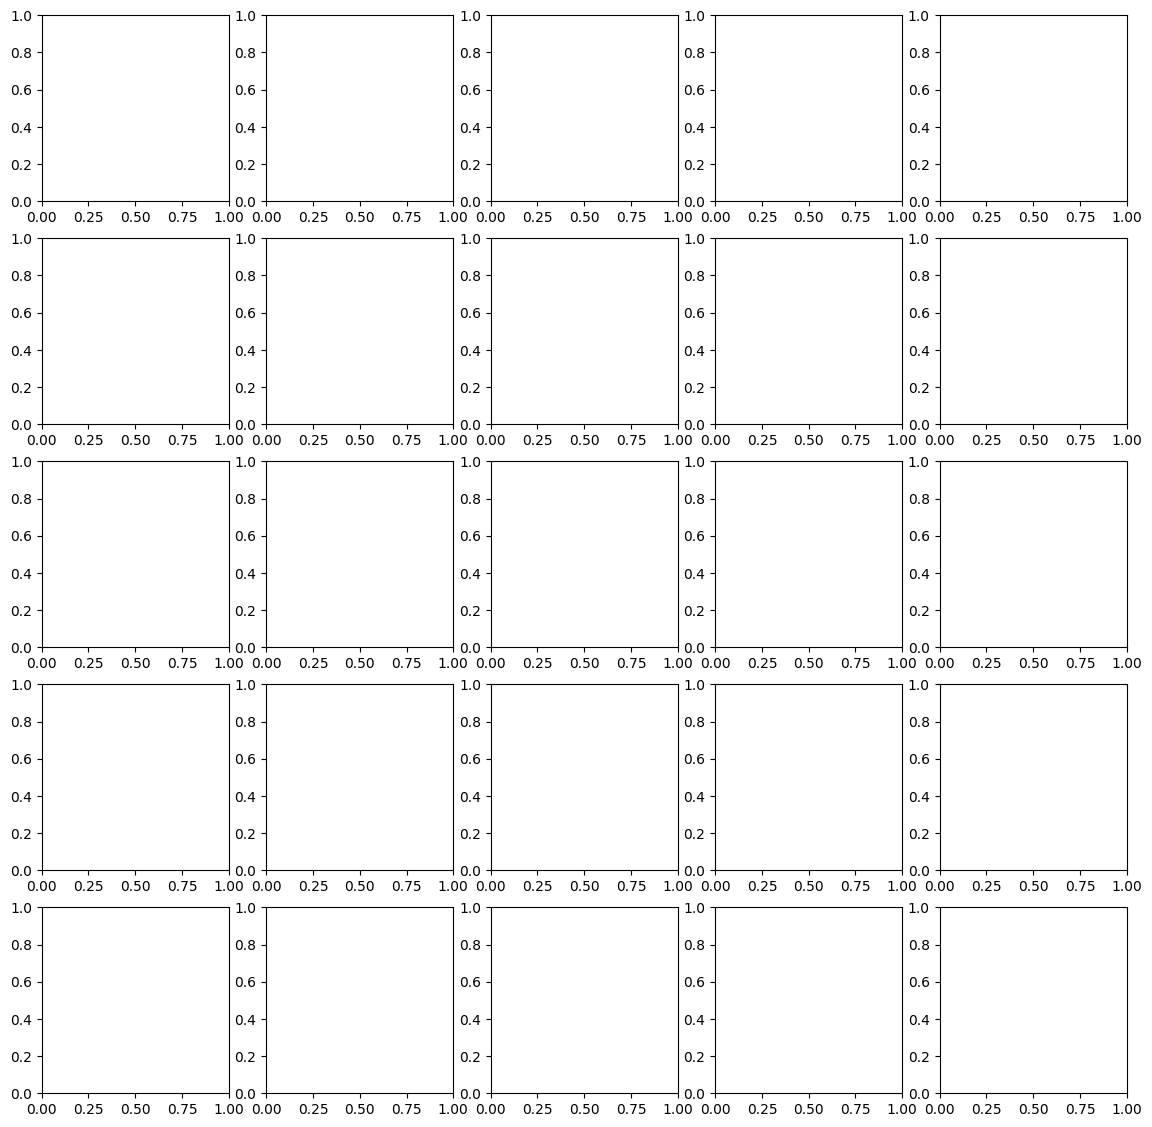

In [ ]:
import matplotlib.pyplot as plt

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(14, 14))

# Iterate through each subplot
for i in range(5):
    for j in range(5):
        # Generate image using decoder and random vector
        index = i * 5 + j
        random_vector = random_vectors[index].view(1, 128, 32, 32)
        image = model.decoder(random_vector).view(512, 512,3)
        
        # Plot the image on the current subplot
        axs[i, j].imshow(image.cpu().detach().numpy().squeeze())
        
        # Add image number as title
        axs[i, j].set_title(f'Image {index + 1}')
        
        # Turn off axis for cleaner plot
        axs[i, j].axis('off')

# Add title for the entire figure
fig.suptitle('New Generated Images', fontsize=16)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()
